# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import datetime
import re
import matplotlib.pyplot as plt
from pprint import pprint


In [2]:
sub_files = glob('../../../*/*.xdf')
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

In [3]:
# Load data for each participant
all_data = {}
for sub_number in range(len(sub_files)): 
    xdf_path = sub_files[sub_number]
    data, header = pyxdf.load_xdf(xdf_path)
    all_data[sub_number] = data


In [4]:
# make df for each modality
all_et_dfs = {}
all_mic_dfs = {}
all_stim_dfs = {}
all_physio_dfs = {}
all_video_dfs = {}
all_eeg_dfs = {}

sub_names = {}

for sub_number in range(len(sub_files)): 
    sub_names[sub_number] = sub_files[sub_number].split('/')[3].split('-')[1]
    streams_collected = [stream['info']['name'][0] for stream in all_data[sub_number]]

    # ET data
    ET = all_data[sub_number][streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)
    et_df['lsl_time_stamp'] = ET['time_stamps']
    et_df['diff'] = et_df['lsl_time_stamp'].diff()
    all_et_dfs[sub_number] = et_df

    # stim
    stim_dat = all_data[sub_number][streams_collected.index('Stimuli_Markers')]
    stim_df = pd.DataFrame(stim_dat['time_series'])
    stim_df.rename(columns={0: 'trigger'}, inplace=True)
    story_onsets = [20, 30, 40, 50, 60, 70]
    stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
    stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
    stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
    stim_df['diff'] = stim_df['lsl_time_stamp'].diff()
    all_stim_dfs[sub_number] = stim_df

    # mic
    mic_data = all_data[sub_number][streams_collected.index('Microphone')]
    mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
    mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
    mic_df['lsl_time_stamp'] = mic_data['time_stamps']
    mic_df['diff'] = mic_df['lsl_time_stamp'].diff()
    all_mic_dfs[sub_number] = mic_df

    # video
    cam_data = all_data[sub_number][streams_collected.index('WebcamStream')]
    cam_data['time_series'][0]
    frame_nums = [int(i[0]) for i in cam_data['time_series']]
    time_pre = [float(i[1]) for i in cam_data['time_series']]
    time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
    time_post = [float(i[3]) for i in cam_data['time_series']]
    cam_df = pd.DataFrame({'frame_num': frame_nums, 
                        'time_pre': time_pre, 
                        'cap_time_ms': time_evnt_ms,
                        'time_post': time_post,
                        'lsl_time_stamp': cam_data['time_stamps']})

    cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
    cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
    cam_df['diff'] = cam_df['lsl_time_sec'].diff()
    all_video_dfs[sub_number] = cam_df


    # eeg
    eeg_dat = all_data[sub_number][streams_collected.index('EGI NetAmp 0')]
    eeg_df = pd.DataFrame(eeg_dat['time_series'])
    eeg_df['lsl_time_stamp'] = eeg_dat['time_stamps']
    eeg_df['diff'] = eeg_df['lsl_time_stamp'].diff()
    all_eeg_dfs[sub_number] = eeg_df

    # physio
    PS = all_data[sub_number][streams_collected.index('OpenSignals')]
    column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
    ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
    ps_df['lsl_time_stamp'] = PS['time_stamps']
    ps_df['diff'] = ps_df['lsl_time_stamp'].diff()
    all_physio_dfs[sub_number] = ps_df
    
    

# Data Loss Graphs

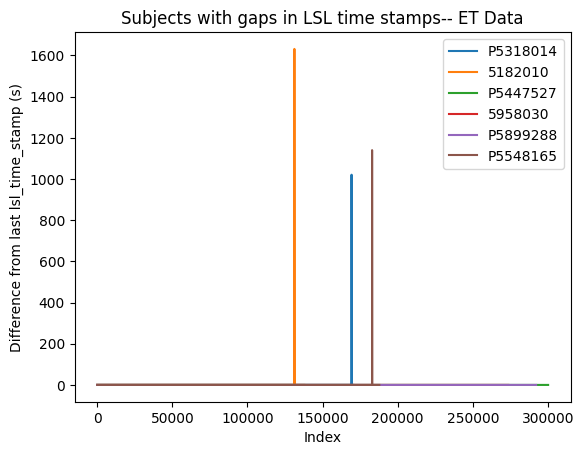

In [152]:
for sub_number in range(len(sub_files)):
    plt.plot(all_et_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- ET Data")
plt.legend()
plt.show()

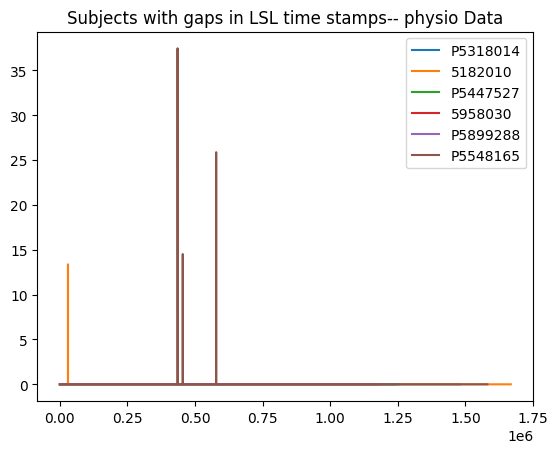

In [ ]:
for sub_number in range(len(sub_files)):
    plt.plot(all_physio_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- Physio Data")
plt.legend()
plt.show()

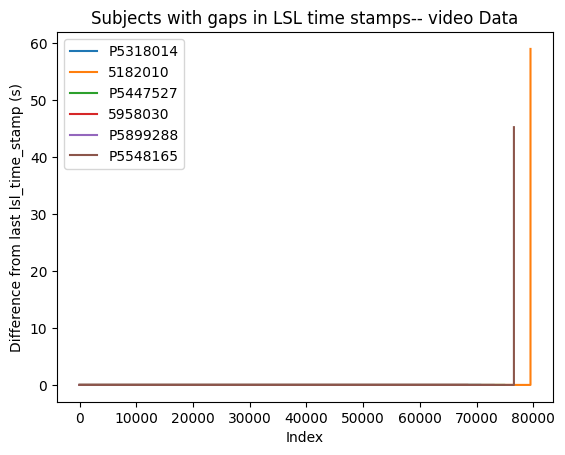

In [153]:
for sub_number in range(len(sub_files)):
    plt.plot(all_video_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- video Data")
plt.legend()
plt.show()

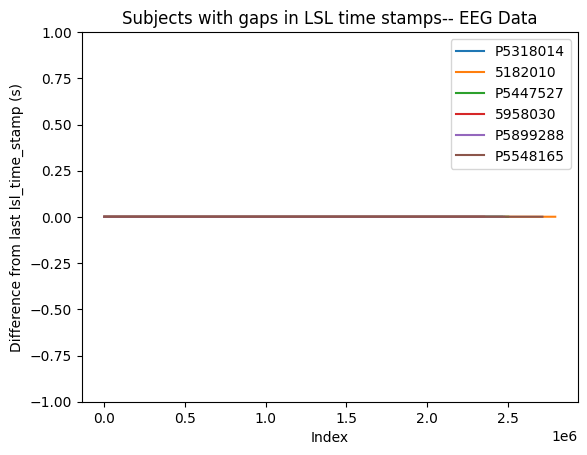

In [158]:
for sub_number in range(len(sub_files)):
    plt.plot(all_eeg_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylim(-1,1)
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')


plt.title("Subjects with gaps in LSL time stamps-- EEG Data")
plt.legend()
plt.show()

In [ ]:
# this makes the kernel crash, do not run
# for sub_number in range(len(sub_files)):
#     plt.plot(all_mic_dfs[sub_number]['diff'], label = sub_names[sub_number])
#     plt.ylim(-1,1)
#     plt.ylabel('Difference from last lsl_time_stamp (s)')
#     plt.xlabel('Index')

# plt.title("Subjects with gaps in LSL time stamps-- mic Data")
# plt.legend()
# plt.show()

# LSL_time_stamp plots

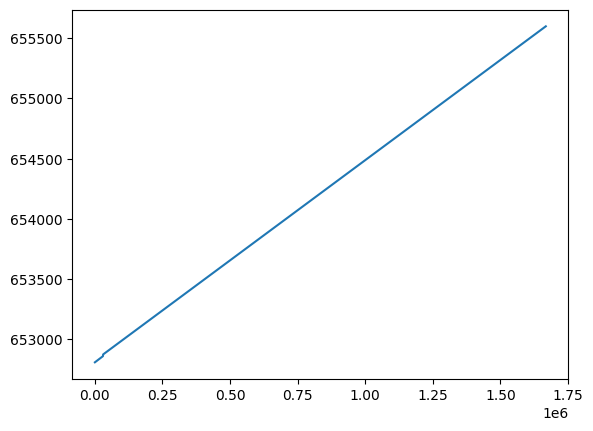

In [80]:
plt.plot(all_physio_dfs[1]['lsl_time_stamp'])

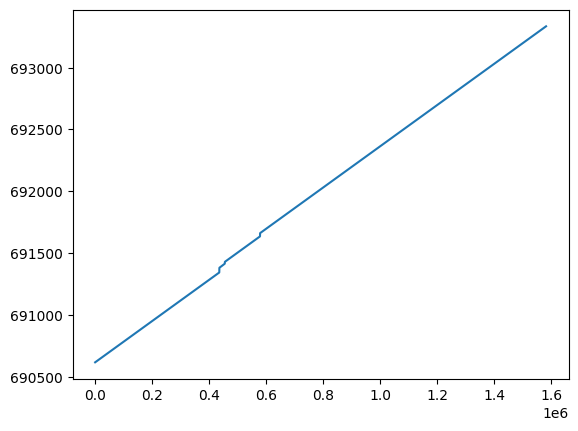

In [81]:
plt.plot(all_physio_dfs[5]['lsl_time_stamp'])

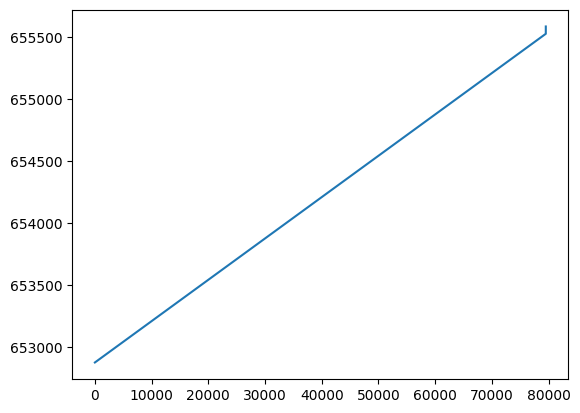

In [82]:
plt.plot(all_video_dfs[1]['lsl_time_stamp'])

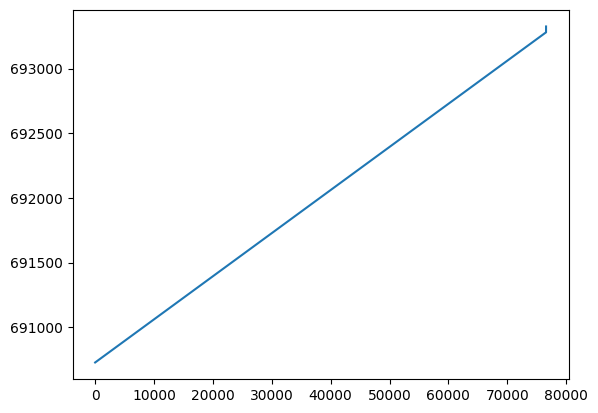

In [83]:
plt.plot(all_video_dfs[5]['lsl_time_stamp'])

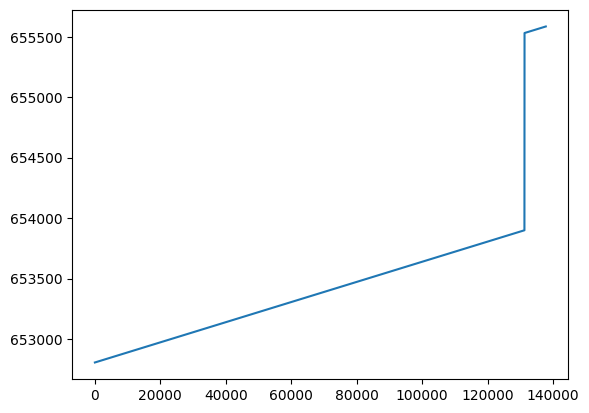

In [84]:
plt.plot(all_et_dfs[1]['lsl_time_stamp'])

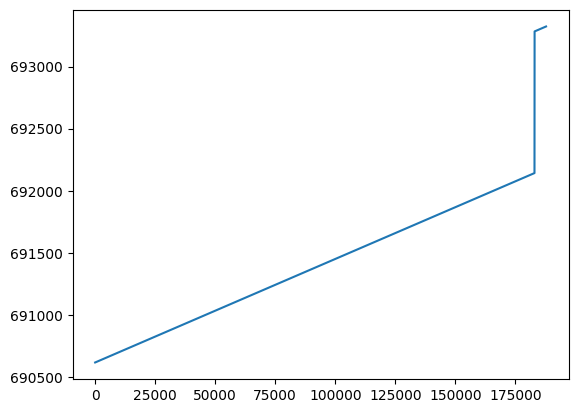

In [ ]:
plt.plot(all_et_dfs[5]['lsl_time_stamp'], label = sub_names[sub_number])

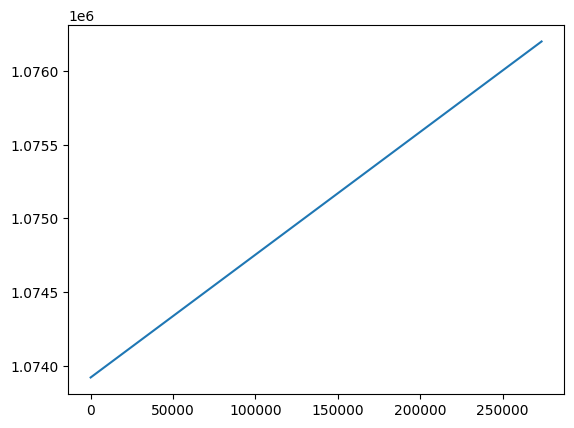

In [ ]:
plt.plot(all_et_dfs[3]['lsl_time_stamp'], label = sub_names[sub_number])

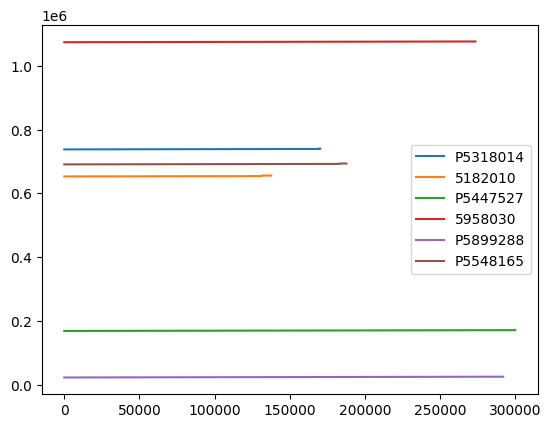

In [ ]:
# plotting them together doesnt work bc different axes
# for sub_number in range(len(sub_files)):
#     plt.plot(all_et_dfs[sub_number]['lsl_time_stamp'], label = sub_names[sub_number])

# plt.legend()


# Percentage of missing data 

In [8]:
# percent of data lost for one sub, one modality

# median diff between lsl_time_stamp (with 1.05 margin) 
median1 = all_et_dfs[0]['diff'].median() * 1.05

# number of loss instances 
loss_instances = (all_et_dfs[0]['diff'] > median1).sum()

if loss_instances != 0:
    # amount of data skipped: values for which diff>median 
    amt_data_lost = all_et_dfs[0].loc[all_et_dfs[0]['diff'] > median1, 'diff'].values[0].sum()
    # total amount of data: last - first lsl_time_stamp
    amt_data_total = all_et_dfs[0]['lsl_time_stamp'].values[-1] - all_et_dfs[0]['lsl_time_stamp'].values[0]

    percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
else:
    percent_lost = 0

print(percent_lost,"%")



41.82 %


In [7]:
sub_files

['../../../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [5]:
# df with percent loss for each sub, each modality
modalities = ['et', 'physio', 'mic', 'video', 'eeg']
percent_list = []

for sub_number in range(len(sub_files)):
    for modality in modalities:
        df = globals()['all_'+modality+'_dfs'][sub_number]
        subject = sub_names[sub_number]
        
        # median diff between lsl_time_stamp (with 1.05 margin) 
        median1 = df['diff'].median() * 1.05
        # number of loss instances  
        loss_instances = (df['diff'] > median1).sum()
        if loss_instances != 0:
            # amount of data skipped: values for which diff>median 
            amt_data_lost = df.loc[df['diff'] > median1, 'diff'].values[0].sum()
            # total amount of data: last - first lsl_time_stamp
            amt_data_total = df['lsl_time_stamp'].values[-1] - df['lsl_time_stamp'].values[0]

            percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
        else:
            percent_lost = 0
        percent_list.append({'sub_num':sub_number, 'subject': subject, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss = pd.DataFrame(percent_list)

In [6]:
percent_data_loss

sub_num   subject modality  num_losses  percent_lost
0         0  P5318014       et           1        41.820
1         0  P5318014   physio           0         0.000
2         0  P5318014      mic           0         0.000
3         0  P5318014    video           0         0.000
4         0  P5318014      eeg           0         0.000
5         1   5182010       et           1        58.696
6         1   5182010   physio           1         0.478
7         1   5182010      mic           0         0.000
8         1   5182010    video           1         2.174
9         1   5182010      eeg           0         0.000
10        2  P5287460       et           0         0.000
11        2  P5287460   physio           1         1.033
12        2  P5287460      mic           0         0.000
13        2  P5287460    video           0         0.000
14        2  P5287460      eeg           0         0.000
15        3  P5447527       et           0         0.000
16        3  P5447527   physio           0         0.000
17        3  P5447527      mic           0         0.000
18        3  P5447527    video           0         0.000
19        3  P5447527      eeg           0         0.000
20        4   5958030       et           0         0.000
21        4   5958030   physio           0         0.000
22        4   5958030      mic           0         0.000
23        4   5958030    video           0         0.000
24        4   5958030      eeg           0         0.000
25        5  P5899288       et           0         0.000
26        5  P5899288   physio           0         0.000
27        5  P5899288      mic           0         0.000
28        5  P5899288    video           0         0.000
29        5  P5899288      eeg           0         0.000
30        6  P5070899       et           0         0.000
31        6  P5070899   physio           0         0.000
32        6  P5070899      mic           0         0.000
33        6  P5070899    video           0         0.000
34        6  P5070899      eeg           0         0.000
35        7  P5548165       et           1        42.149
36        7  P5548165   physio           3         1.379
37        7  P5548165      mic           0         0.000
38        7  P5548165    video           1         1.739
39        7  P5548165      eeg           0         0.000

In [7]:
nonzero_loss = percent_data_loss[percent_data_loss['percent_lost'] != 0]
nonzero_loss

sub_num   subject modality  num_losses  percent_lost
0         0  P5318014       et           1        41.820
5         1   5182010       et           1        58.696
6         1   5182010   physio           1         0.478
8         1   5182010    video           1         2.174
11        2  P5287460   physio           1         1.033
35        7  P5548165       et           1        42.149
36        7  P5548165   physio           3         1.379
38        7  P5548165    video           1         1.739